In [147]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

<h2>Load Data</h2>

In [116]:
df = pd.read_csv("US_Accidents_March23.csv", index_col="ID")

<h2>Data Cleaning</h2>

In [117]:
# print data types
print(df.dtypes)

Source                    object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Street                    object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity                     bool
Bump                        bool
Crossing  

In [120]:
# coerce data types, where necessary
df["Start_Time"] = pd.to_datetime(df["Start_Time"])
df["End_Time"] = pd.to_datetime(df["End_Time"])

In [121]:
# drop columns with only one unique value
df = df.drop(columns=["Country", "Turning_Loop"])

In [123]:
# investigate normal ranges
def iqr_rule(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    large_outliers = (col < q1 - 1.5 * (q3 - q1))
    small_outliers = (col > q3 + 1.5 * (q3 - q1))
    return (large_outliers + small_outliers).mean()


outliers = pd.DataFrame(
    index=[col for col in df[numerical_columns]],
    data={
        "min_value": df[numerical_columns].min(axis=0),
        "max_value": df[numerical_columns].max(axis=0),
        "outlier_percent": [iqr_rule(small_df[col]) for col in df[numerical_columns]]
    }
)
print(outliers)

                    min_value    max_value  outlier_percent
Precipitation(in)    0.000000    36.470000         0.064441
Wind_Speed(mph)      0.000000  1087.000000         0.029633
Visibility(mi)       0.000000   140.000000         0.190476
Pressure(in)         0.000000    58.630000         0.054865
Humidity(%)          1.000000   100.000000         0.000000
Wind_Chill(F)      -89.000000   207.000000         0.006211
Temperature(F)     -89.000000   207.000000         0.007764
Distance(mi)         0.000000   441.750000         0.123447
End_Lng           -124.545748   -67.109242         0.000000
End_Lat             24.566013    49.075000         0.000000
Start_Lng         -124.623833   -67.113167         0.000000
Start_Lat           24.554800    49.002201         0.000000


In [124]:
# drop numerical outliers
num_rows = len(df)
df = df[df["Wind_Speed(mph)"] <= 231] # fastest recorded wind speed in the western hemisphere
df = df[(df["Pressure(in)"] >= 26) & (df["Pressure(in)"] <= 32)] # see paper citations
df = df[(df["Wind_Chill(F)"] >= -80) & (df["Wind_Chill(F)"] <= 134)] # see paper citations
df = df[(df["Temperature(F)"] >= -80) & (df["Temperature(F)"] <= 134)] # see paper citations
df = df[df["Distance(mi)"] <= 20] # this cutoff was tougher, this excludes about 0.1% of the data (440 miles is too long)
print("# of Rows Dropped: ", num_rows - len(df))

# of Rows Dropped:  2206931


In [125]:
# Search for Potential Weird Values
for col in df:
    print("Column Name: ", col)
    print("Unique Values: ", df[col].unique())
    print("--------------")

Column Name:  Source
Unique Values:  ['Source2' 'Source3' 'Source1']
--------------
Column Name:  Severity
Unique Values:  [2 3 1 4]
--------------
Column Name:  Start_Time
Unique Values:  ['2016-02-08T06:49:27.000000000' '2016-02-08T07:23:34.000000000'
 '2016-02-08T07:39:07.000000000' ... '2019-08-23T19:11:30.000000000'
 '2019-08-23T19:00:21.000000000' '2019-08-23T18:52:06.000000000']
--------------
Column Name:  End_Time
Unique Values:  ['2016-02-08T07:19:27.000000000' '2016-02-08T07:53:34.000000000'
 '2016-02-08T08:09:07.000000000' ... '2019-08-23T19:28:49.000000000'
 '2019-08-23T19:29:42.000000000' '2019-08-23T19:21:31.000000000']
--------------
Column Name:  Start_Lat
Unique Values:  [39.063148 39.747753 39.627781 ... 34.26103  33.7417   34.239104]
--------------
Column Name:  Start_Lng
Unique Values:  [ -84.032608  -84.205582  -84.188354 ... -118.416176 -117.14806
 -117.84779 ]
--------------
Column Name:  End_Lat
Unique Values:  [      nan 40.11206  39.170476 ... 34.239104 32.76

Unique Values:  ['SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'Variable' 'North'
 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' 'S' 'VAR' 'CALM' 'N' nan]
--------------
Column Name:  Wind_Speed(mph)
Unique Values:  [  3.5   4.6   5.8   6.9   8.1  10.4   9.2  11.5  13.8  15.   12.7  19.6
  21.9  18.4  25.3  16.1  24.2  23.   20.7  17.3  10.    5.   26.5  28.8
  40.3  32.2   8.    9.    3.   14.    7.    0.   12.    6.   13.    1.
   2.   17.   16.   21.   28.   20.   26.   18.   22.   31.1  29.9  38.
  24.   27.6  35.7  33.4  36.8  34.5  30.   29.   25.   39.1  54.1  32.
  33.   31.  132.   43.   35.   37.   36.   41.   40.   44.  188.   53.
  52.   79.   51.   59.   70.   46.   45.  119.   75.   39.  129.  128.
  67.   49.  116.   82.  145.   98.   66.   64.  117.   93.  230.   58.
 161.  113.  127.  157.  175.   42.6  41.4  49.5  77.1  51.8  47.2  60.
  48.3  43.7  48.  190.   81.   55.  100.  122.  105.  185.  107.   61.
  47.  121.  130.  125.  110.  211.  131.   54.  169.   

In [126]:
# limit dataset size if desired in order to decrease computation time
# SAMPLE_RATIO = 15_000 / len(df)
SAMPLE_RATIO = 1.0
df = df.sample(frac=SAMPLE_RATIO)

In [136]:
# drop other columns we exclude for various reasons
df = df.drop(columns=[
    "Source",
    "Description",
    "Street",
    "City",
    "County",
    "State",
    "Zipcode",
    "Airport_Code",
    "Weather_Timestamp",
    "Wind_Direction",
    "Weather_Condition",
    "Sunrise_Sunset",
    "Civil_Twilight",
    "Nautical_Twilight",
    "Astronomical_Twilight"
])

In [137]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns="Severity"), df["Severity"], test_size=0.15)

In [138]:
# Missing Values
missing = pd.DataFrame(
    index=[col for col in df if df[col].isna().any()],
    data={"Missing Data (%)": [100 * df[col].isna().sum() / len(df) for col in df if df[col].isna().any()]},
)
print(missing)

                   Missing Data (%)
End_Lat                   34.027123
End_Lng                   34.027123
Humidity(%)                0.146519
Visibility(mi)             0.312924
Precipitation(in)          8.082387


In [139]:
# drop columns with large proportions of missing data
X_train = X_train.drop(columns=["End_Lat", "End_Lng"])
X_test = X_test.drop(columns=["End_Lat", "End_Lng"])
y_train = y_train.drop(columns=["End_Lat", "End_Lng"])
y_test = y_test.drop(columns=["End_Lat", "End_Lng"])

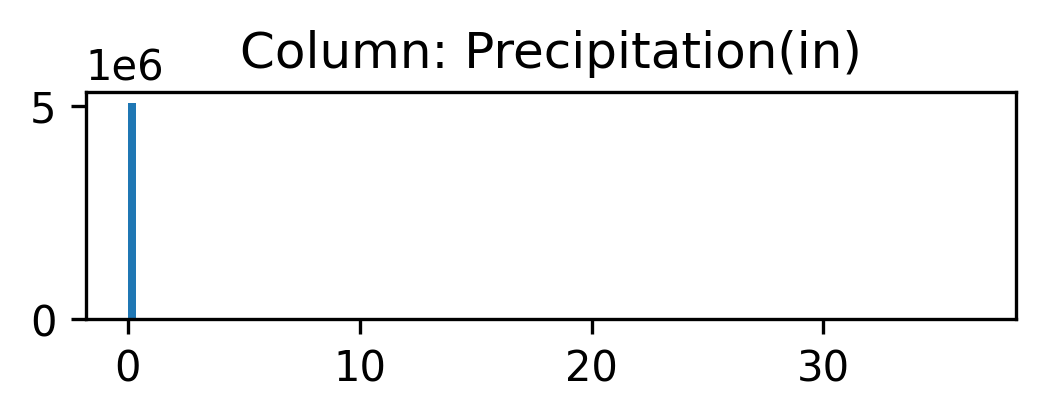

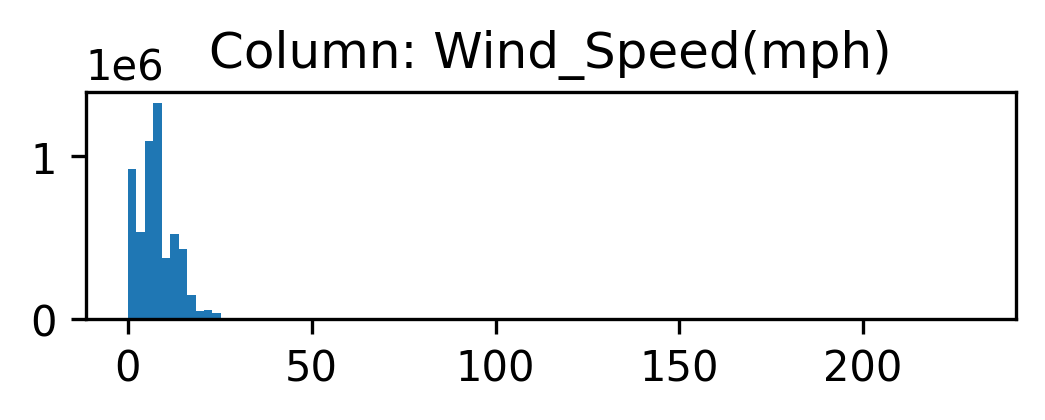

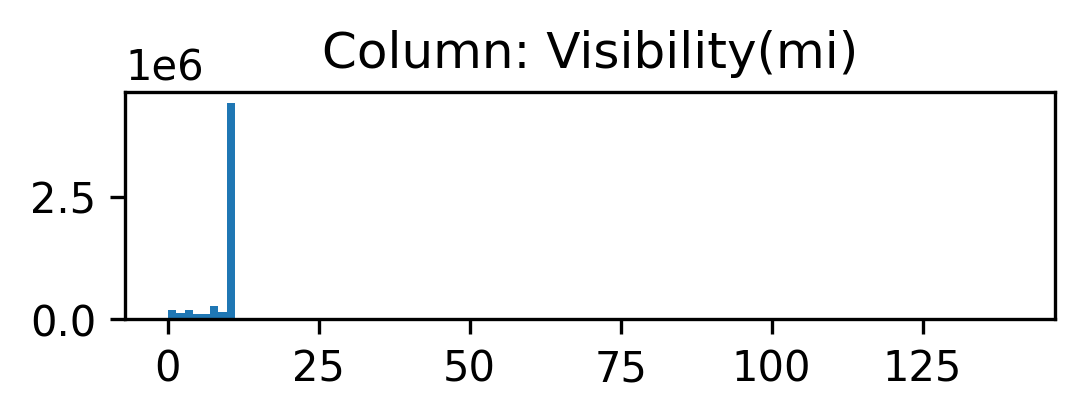

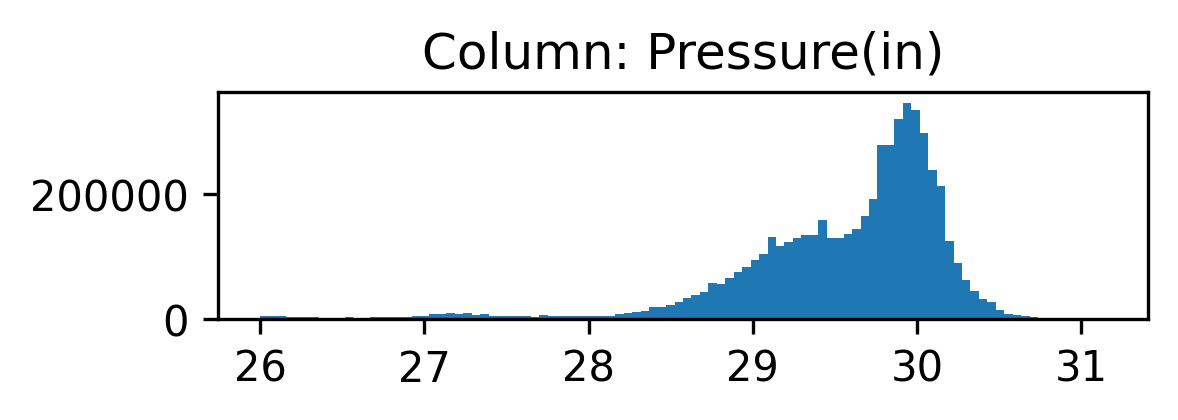

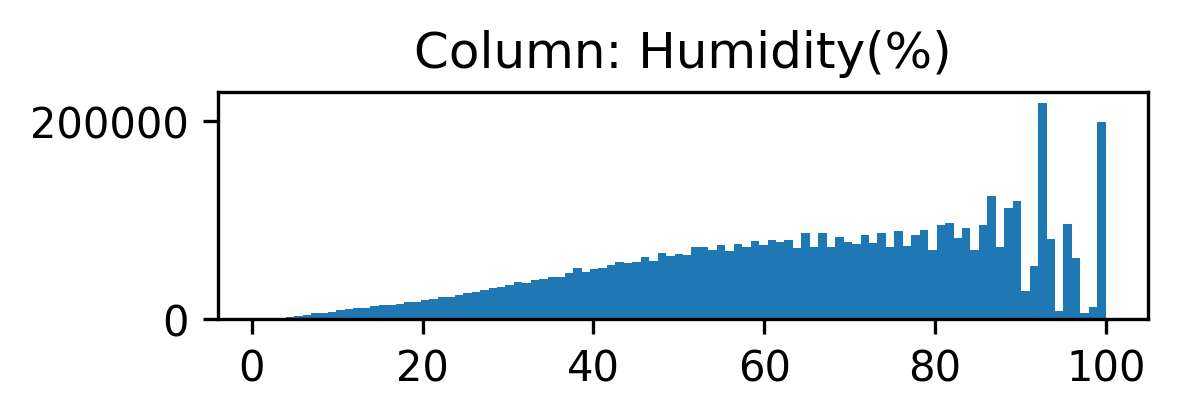

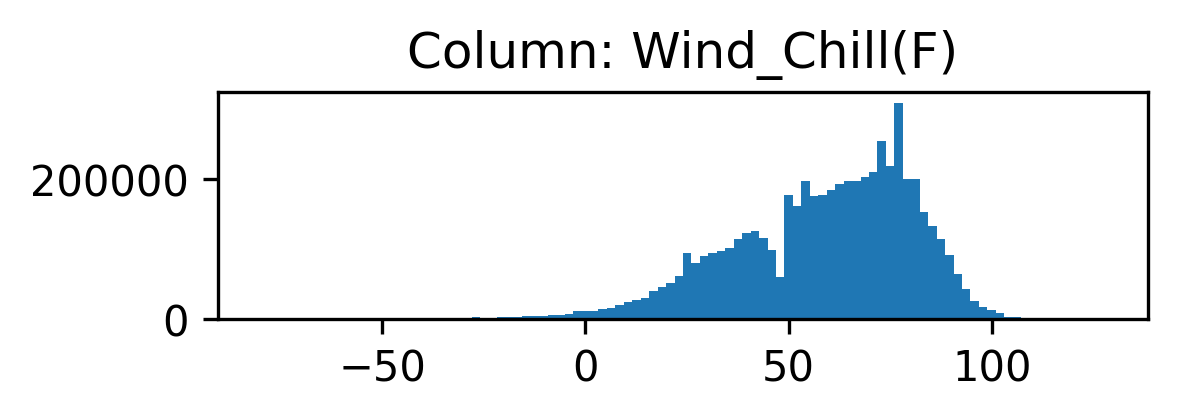

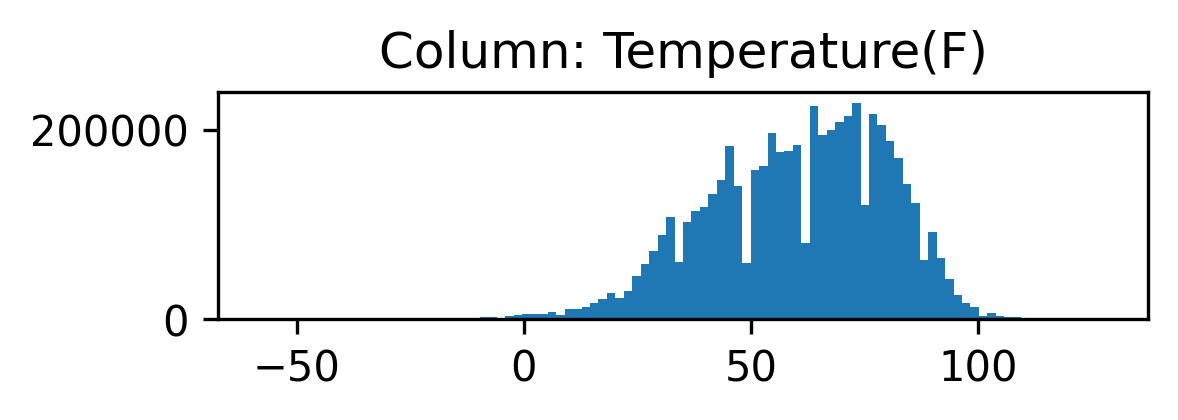

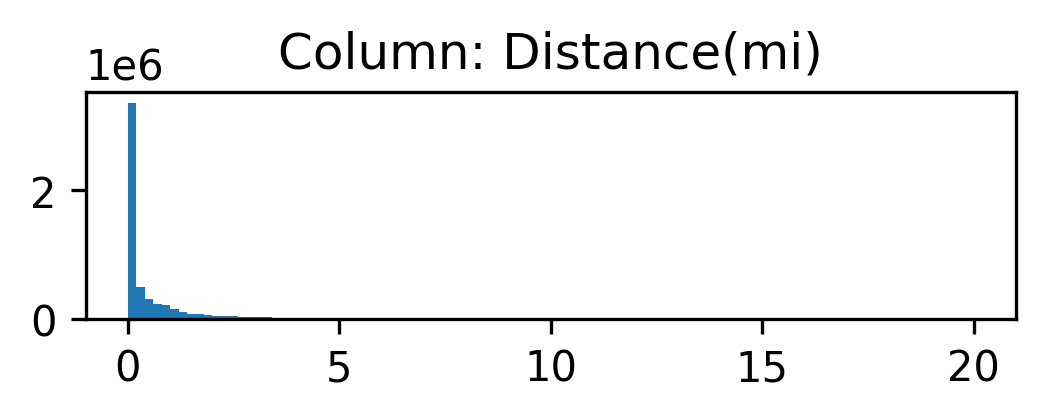

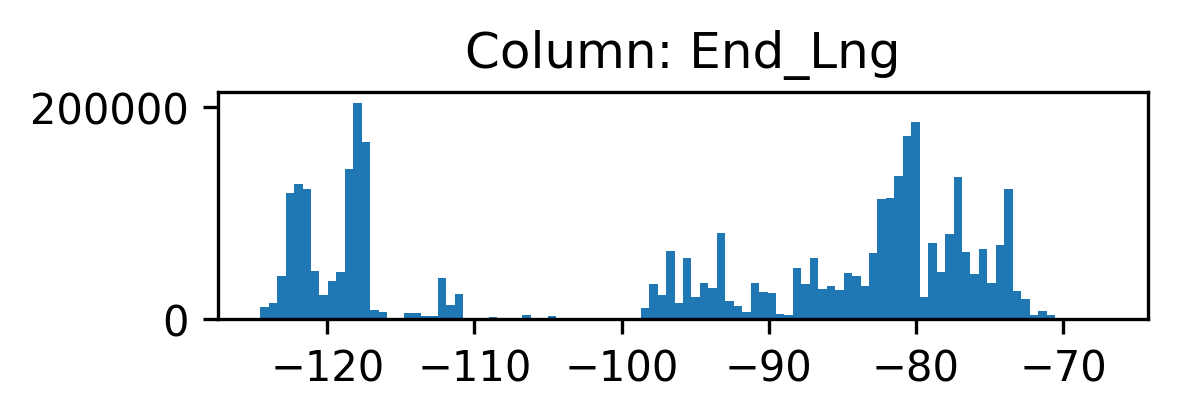

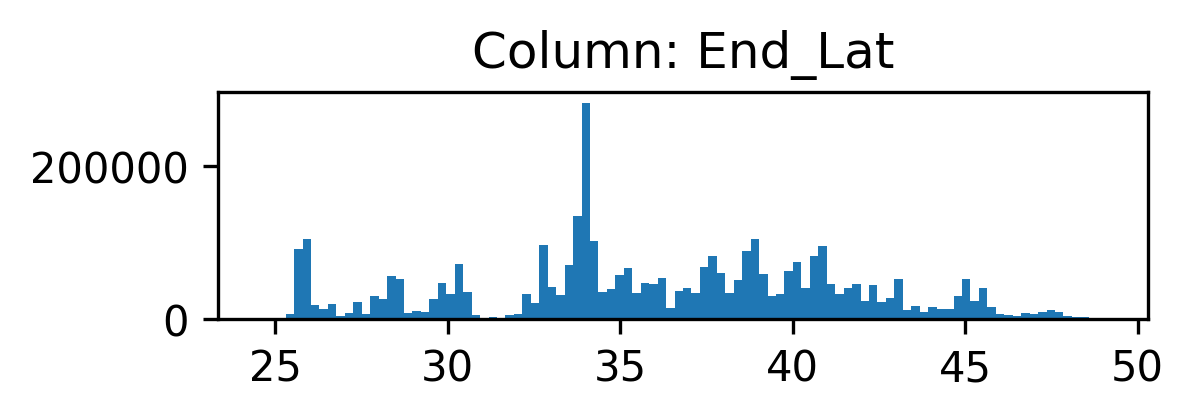

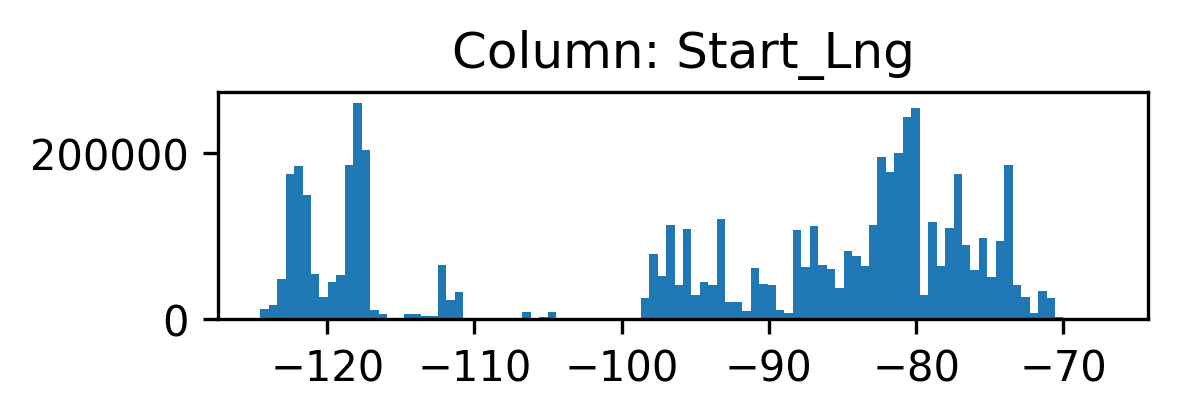

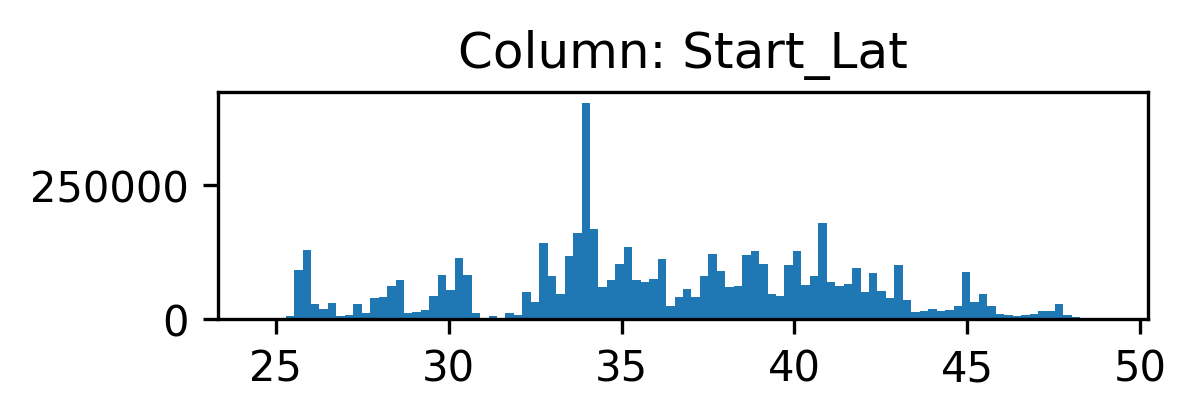

In [140]:
# plot histograms of each numeric column to determine whether to apply mean or median imputation (median seems reasonable for most)
numeric_columns = ["Precipitation(in)", "Wind_Speed(mph)", "Visibility(mi)", "Pressure(in)", "Humidity(%)", "Wind_Chill(F)", "Temperature(F)", "Distance(mi)", "End_Lng", "End_Lat", "Start_Lng", "Start_Lat"]


for col in df[numeric_columns]:
    fig = plt.figure(figsize=(4, 1))
    ax = fig.add_subplot(111)
    ax.hist(df[col], bins=100)
    ax.set_title(f"Column: {col}")
    plt.show()

In [150]:
# data imputation
need_imputation = ["Humidity(%)", "Visibility(mi)", "Precipitation(in)"]

imputation_strategy = {
    "Humidity(%)": "median",
    "Visibility(mi)": "median",
    "Precipitation(in)": "median",
}

for col in need_imputation:
    imputer = SimpleImputer(strategy=imputation_strategy[col])
    X_train[col] = imputer.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = imputer.transform(X_test[col].values.reshape(-1, 1))

In [154]:
# save data files
VERSION=1
X_train.to_csv(f"X_train_v{VERSION}")
X_test.to_csv(f"X_test_v{VERSION}")
y_train.to_csv(f"y_train_v{VERSION}")
y_test.to_csv(f"y_test_v{VERSION}")